In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
#useful functions 
def area_of_triangle(A,B,C):
    """
    computes the area of a triangle given by 3 points in 2d or 3d coordinates
    A, B and C must be numpy arrays
    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3]
    or matrices
    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]
    """
    
    As = A.shape
    Bs = B.shape
    Cs = C.shape
    
    if len(As) == 1 : 
        #we got vectors
        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):
            raise Exception('coordinates can only be 2d or 3d')
            return None
    else:
        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):
            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):
                raise Exception('vectors must be the same size')
                return None
            else:
                #move forward
                pass
        else:
            raise Exception('coordinates can only be 2d or 3d')
            return None
        
    
    #at this point we know that one of the dimensions has 2 or 3 elements we move  forward assuming that 
    #the user provided the vectors with the correct size

    #move all vectors to the same origin -> A
    AB = B-A
    AC = C-A
    
    if len(As) == 1 :
        #if only one vector then simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))
    else:
        #if  multiple vectors compute the norm along the axis one 
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)    
    
    return area
    
def concordance_correlation_coefficient(s1, s2):
    N1 = len(s1)
    N2 = len(s2)
    if N1==N2:
        N = N1
    elif N1>N2:
        s1 = s1[0:N2]
        N = N2
    elif N1<N2:
        s2 = s2[0:N1]
        N = N1
        
    m_s1 = np.mean(s1)
    m_s2 = np.mean(s2)
    
    s1_nomean = s1-m_s1
    s2_nomean = s2-m_s2
    
    s1_ss2 = (1/N)*np.sum((s1_nomean)**2)
    s2_ss2 = (1/N)*np.sum((s2_nomean)**2)
       
    s1s2 = (1/N)*np.sum(np.multiply(s1_nomean,s2_nomean)) # np.multiply(A,B) -> element wise multiplication between matrices A and B
    
    p = (2*s1s2)/(s1_ss2 + s2_ss2 +(m_s1 - m_s2)**2)
    
    return p


def get_mouth_positions_3d(DF_3dpositions):
    
    #DF_3dpositions is a DataFrame

    #we are goinf to focus on the rihgt and left corners of the mouth and the top and bottom lips 
    #these positions correspond to landmarks 48, 54 and 51, 57 respectivelly

    Right_corner = DF_3dpositions.filter(like='landmark_48')
    Right_corner_x = Right_corner.iloc[1:,[0]].values
    Right_corner_y = Right_corner.iloc[1:,[1]].values
    Right_corner_z = Right_corner.iloc[1:,[2]].values
    Right_Corner_Coord = np.column_stack((Right_corner_x.astype(np.double),Right_corner_y.astype(np.double),Right_corner_z.astype(np.double)))

    Left_corner = DF_3dpositions.filter(like='landmark_54')
    Left_corner_x = Left_corner.iloc[1:,[0]].values
    Left_corner_y = Left_corner.iloc[1:,[1]].values
    Left_corner_z = Left_corner.iloc[1:,[2]].values
    Left_Corner_Coord = np.column_stack((Left_corner_x.astype(np.double),Left_corner_y.astype(np.double),Left_corner_z.astype(np.double)))

    Top_lip = DF_3dpositions.filter(like='landmark_51')
    Top_lip_x = Top_lip.iloc[1:,[0]].values
    Top_lip_y = Top_lip.iloc[1:,[1]].values
    Top_lip_z = Top_lip.iloc[1:,[2]].values
    Top_Lip_Coord = np.column_stack((Top_lip_x.astype(np.double),Top_lip_y.astype(np.double),Top_lip_z.astype(np.double)))

    Bottom_lip = DF_3dpositions.filter(like='landmark_57')
    Bottom_lip_x = Bottom_lip.iloc[1:,[0]].values
    Bottom_lip_y = Bottom_lip.iloc[1:,[1]].values
    Bottom_lip_z = Bottom_lip.iloc[1:,[2]].values
    Bottom_Lip_Coord = np.column_stack((Bottom_lip_x.astype(np.double),Bottom_lip_y.astype(np.double),Bottom_lip_z.astype(np.double)))

    
    return Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord

#     mouth_corners = np.zeros((len(Right_Corner_Coord),1))
#     top_bottom = np.zeros((len(Right_Corner_Coord),1))
#     for i in range(len(Right_Corner_Coord)):
#         mouth_corners[i] = np.sqrt((Right_Corner_Coord[i,0]-Left_Corner_Coord[i,0])**2+(Right_Corner_Coord[i,1]-Left_Corner_Coord[i,1])**2+(Right_Corner_Coord[i,2]-Left_Corner_Coord[i,2])**2)
#         top_bottom[i] = np.sqrt((Top_Lip_Coord[i,0]-Bottom_Lip_Coord[i,0])**2+(Top_Lip_Coord[i,1]-Bottom_Lip_Coord[i,1])**2+(Top_Lip_Coord[i,2]-Bottom_Lip_Coord[i,2])**2)



In [7]:
# this is a generic place holder for all the variables that will be compute
# when a video is processed, a new class is generated and some of the variables will be modified with an actual value  

class Variables_Placeholder(object):
    
    def __init__(self):
        
        Subject_ID = np.nan
        Subject_status = np.nan
        A_mean_rest = np.nan
        A_right_mean_rest = np.nan
        A_left_mean_rest = np.nan
        TB_mean_REST = np.nan
        Duration_var_PA = np.nan
        Max_TB_PA = np.nan
        Max_TB_vel_PA = np.nan
        Min_TB_vel_PA = np.nan
        TB_path_cmd_BBP = np.nan
        Max_TB_BBP = np.nan
        Max_TB_vel_BBP = np.nan
        Min_TB_vel_BBP = np.nan
        A_mean_BBP = np.nan
        Delta_A_BBP = np.nan
        CCC_A_left_A_right_BBP = np.nan
        A_mean_BIGSMILE = np.nan
        Delta_A_BIGSMILE = np.nan
        CCC_A_left_A_right_BIGSMILE = np.nan

In [8]:
# get all files in path and process each one. Show progress with a bar
paths = [r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Healthy', r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Parkinsons']
#r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\example'

tasks = ['REST', 'PA', 'BBP', 'BIGSMILE']

# Features = Variables_placeholder()


columnsDF = [ 
            'Subject_ID', 
            'Subject_status', 
            'A_mean_rest', 
            'A_right_mean_rest', 
            'A_left_mean_rest', 
            'TB_mean_REST',         
            'Duration_var_PA', 
            'Max_TB_PA',
            'Max_TB_vel_PA', 
            'Min_TB_vel_PA'
            ]

DataFrameResults = pd.DataFrame(columns=columnsDF)

#get REST values first as they will be used to normalize additional values
for path in paths:
    Files = os.listdir(path)            
    ext='Landmarks3D.csv'
    Files = [i for i in Files if ext in i]
    for k,f in enumerate(Files):
        Files[k] = os.path.join(path,f)
        
        Features = Variables_Placeholder()
        
        Features.Subject_ID = f[0:4]  #get subject ID from file name
        Features.Subject_status = f[0:2] #get disease status from file name
        
        this_task = None
        
        for t in tasks: 
            if t in f: this_task = t  #get task from file name
              
        DataFrame3dInfo = pd.read_csv(Files[k])
        Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord = get_mouth_positions_3d(DataFrame3dInfo)  # get the four corners of the mouth :) 
        
        #operations at rest
        try:
            if this_task is 'REST':
                # i will consider only the middle 20% of the video to take the measurements 
                # this is done with the assumption that the subject was at 'rest' at least during the middle of the video 
                mid_point = len(Right_Corner_Coord)//2
                init_point = mid_point-int(len(Right_Corner_Coord)*0.1)
                end_point = mid_point+int(len(Right_Corner_Coord)*0.1)

                A_left = np.zeros((end_point-init_point))
                A_right = np.zeros((end_point-init_point))
                A = np.zeros((end_point-init_point))
                TB = np.zeros((end_point-init_point))

                A_l = area_of_triangle(Left_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                A_r = area_of_triangle(Right_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
                A = A_l  + A_r

                TB = np.sqrt((Top_Lip_Coord[init_point:end_point,0]-Bottom_Lip_Coord[init_point:end_point,0])**2+(Top_Lip_Coord[init_point:end_point,1]-Bottom_Lip_Coord[init_point:end_point,1])**2+(Top_Lip_Coord[init_point:end_point,2]-Bottom_Lip_Coord[init_point:end_point,2])**2)

                Features.A_mean_rest = np.mean(A)
                Features.A_right_mean_rest = np.mean(A_r)
                Features.A_left_mean_rest = np.mean(A_l)
                Features.TB_mean_REST = np.mean(TB)

                DataFrameResults = DataFrameResults.append(Features.__dict__, ignore_index=True)
        except:
            pass

        
DataFrameResults

,Subject_ID,Subject_status,A_mean_rest,A_right_mean_rest,A_left_mean_rest,TB_mean_REST,Duration_var_PA,Max_TB_PA,Max_TB_vel_PA,Min_TB_vel_PA
0,NF12,NF,0.000386,0.000184,0.000201,0.015733,NaN,NaN,NaN,NaN
1,NF13,NF,0.000317,0.000153,0.000164,0.013391,NaN,NaN,NaN,NaN
2,NF14,NF,0.000396,0.000188,0.000207,0.015260,NaN,NaN,NaN,NaN
3,NF15,NF,0.000264,0.000140,0.000124,0.010892,NaN,NaN,NaN,NaN
4,NF16,NF,0.000288,0.000142,0.000146,0.011187,NaN,NaN,NaN,NaN
5,NF17,NF,0.000221,0.000105,0.000117,0.009351,NaN,NaN,NaN,NaN
6,NF18,NF,0.000294,0.000146,0.000148,0.012368,NaN,NaN,NaN,NaN
7,NF19,NF,0.000237,0.000112,0.000125,0.009456,NaN,NaN,NaN,NaN
8,NF20,NF,0.000371,0.000173,0.000198,0.016611,NaN,NaN,NaN,NaN
9,NF21,NF,0.000245,0.000105,0.000140,0.009536,NaN,NaN,NaN,NaN


In [9]:
paths = [r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Healthy', r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Parkinsons']
tasks = ['REST', 'PA', 'BBP', 'BIGSMILE']

window_lenght_filter = 5

results = dict()

frames_interest = pd.read_csv('./data/trial_frames.csv')

for path in paths:
    Files = os.listdir(path)            
    ext='Landmarks3D.csv'
    Files = [i for i in Files if ext in i]
    for k,f in enumerate(Files):
        Files[k] = os.path.join(path,f)
        
        Features = Variables_Placeholder()
        
        Features.Subject_ID = f[0:4]  #get subject ID from file name
        Features.Subject_status = f[0:2] #get disease status from file name
            
            
        this_task = None
        
        for t in tasks: 
            if t in f: this_task = t  #get task from file name
             
        DataFrame3dInfo = pd.read_csv(Files[k])
        Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord = get_mouth_positions_3d(DataFrame3dInfo)  # get the four corners of the mouth :) 
        time_sec = DataFrame3dInfo['Time_Stamp (s)'].values[1:]
        

        
        if this_task is 'PA':
            # i will consider only the middle 20% of the video to take the measurements 
            # this is done with the assumption that the subject was at 'rest' at least during the middle of the video 
            init_point = frames_interest['init_Frame'][(frames_interest.Subject_ID == Features.Subject_ID) & (frames_interest.Task == this_task)].values[0]
            end_point = frames_interest['end_Frame'][(frames_interest.Subject_ID == Features.Subject_ID) & (frames_interest.Task == this_task)].values[0]
            if np.isnan(init_point):
                mid_point = len(Right_Corner_Coord)//2
                init_point = mid_point-int(len(Right_Corner_Coord)*0.3)
                end_point = mid_point+int(len(Right_Corner_Coord)*0.3)
            else:
                init_point = int(init_point)
                end_point = int(end_point)

            A_l = area_of_triangle(Left_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
            A_r = area_of_triangle(Right_Corner_Coord[init_point:end_point,:], Top_Lip_Coord[init_point:end_point,:], Bottom_Lip_Coord[init_point:end_point,:])
            A = A_l  + A_r

            TB = np.sqrt((Top_Lip_Coord[init_point:end_point,0]-Bottom_Lip_Coord[init_point:end_point,0])**2+(Top_Lip_Coord[init_point:end_point,1]-Bottom_Lip_Coord[init_point:end_point,1])**2+(Top_Lip_Coord[init_point:end_point,2]-Bottom_Lip_Coord[init_point:end_point,2])**2)
            
            break
            fig, ax = plt.subplots(1,2, figsize=(20,5))
    
            ax[0].plot(A ,alpha=0.5)
            ax[1].plot(TB ,alpha=0.5)
            ax[0].set_title(Features.Subject_ID)
            plt.show()
        

(125, 1175)

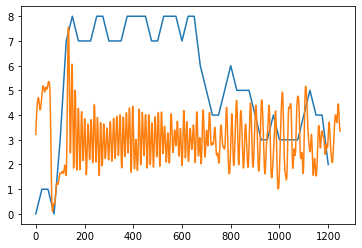

In [281]:
nwin = 50
overlap = 50; #in %
noverlap = int(nwin*(overlap/100))
zer = []
posi = []
step = nwin - noverlap

fs = int(1/time_sec[1])
nyq = 0.5 * fs
lowcut = 0.25
highcut = 5
order = 6
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(order, [low, high], btype='band')
lp_signal  = signal.filtfilt(b, a, A)



sequence = lp_signal

for i in range(0, len(sequence) - nwin + 1, step):
    window = sequence[i:i+nwin] #this is a view, not a copy
    #window = ndimage.gaussian_filter(window,5)
    zero_crossings =np.where(np.diff(np.sign(window)))[0]
    zer.append(len(zero_crossings))
    posi.append(i)
    
plt.plot(posi, zer)
plt.plot(lp_signal*10000+3)


first_time = False
last_time = False
for k, zeros in enumerate(zer):
    if (zeros>=3) and (first_time is False):
        init_position = posi[k+1]
        first_time = True
        
    if (zeros<3) and (first_time is True):
        end_position = posi[k-1]
        break
        
init_position, end_position

In [260]:
valid_pos

(array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
        76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91], dtype=int64),)

In [285]:
fs = int(1/time_sec[1])
nyq = 0.5 * fs
lowcut = 2
highcut = 5
order = 6
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(order, [low, high], btype='band')
lp_signal  = signal.filtfilt(b, a, A)
vel_signal = np.gradient(lp_signal, time_sec[init_point:end_point])
lp_vel_signal = signal.filtfilt(b, a, vel_signal)
fig, ax = plt.subplots(2,1, figsize=(20,10))
    
ax[0].plot(lp_signal ,alpha=0.5)
ax[0].plot(A-np.mean(A), alpha = 0.5)
ax[0].set_title(Features.Subject_ID)
ax[1].plot(lp_vel_signal ,alpha=0.5)





In [282]:
%matplotlib qt
fs = int(1/time_sec[1])
nyq = 0.5 * fs
lowcut = 0.1
highcut = 5
order = 3
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(order, [low, high], btype='band')
lp_signal  = signal.filtfilt(b, a, A)
vel_signal = np.gradient(lp_signal, time_sec[init_point:end_point])
lp_vel_signal = signal.filtfilt(b, a, vel_signal)

peaks_pos, _ = signal.find_peaks(lp_vel_signal,distance = 10,width=5)
peaks_neg, _ = signal.find_peaks(-lp_vel_signal,distance = 10,width=5)

zero_crossings = np.where(np.diff(np.sign(lp_vel_signal)))[0]
#peaks_neg, _ = signal.find_peaks(-vel_signal, height=0.05)
fig, ax = plt.subplots(1,1, figsize=(20,10))

plt.plot(lp_signal ,alpha=0.5)
plt.scatter(peaks_pos,lp_signal[peaks_pos],c='r' )
plt.scatter(peaks_neg,lp_signal[peaks_neg],c='g' )
plt.scatter(zero_crossings,lp_signal[zero_crossings],c='m' )

In [236]:
zero_crossings = np.where(np.diff(np.sign(lp_signal)))[0]
#plt.plot(zero_crossings,time_sec[zero_crossings],'o')
plt.plot(lp_signal ,alpha=0.5)
plt.scatter(zero_crossings,lp_signal[zero_crossings],c='m' )

In [216]:
th_pos = np.mean(lp_vel_signal[peaks_pos])*0.3
th_neg = np.median(lp_vel_signal[peaks_neg])*0.3
peaks_pos_new, _ = signal.find_peaks(lp_vel_signal,distance = 10, threshold=th_pos )
peaks_neg_new, _ = signal.find_peaks(-lp_vel_signal,distance = 10, threshold=th_neg)
fig, ax = plt.subplots(1,1, figsize=(20,10))

plt.plot(lp_vel_signal ,alpha=0.5)
plt.scatter(peaks_pos_new,lp_vel_signal[peaks_pos_new],c='r' )
plt.scatter(peaks_neg_new,lp_vel_signal[peaks_neg_new],c='g' )

C:\Users\GuarinD\.conda\envs\pytorch_deploy\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GuarinD\.conda\envs\pytorch_deploy\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GuarinD\.conda\envs\pytorch_deploy\lib\site-packages\scipy\signal\_peak_finding.py:718: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmin <= min_thresholds)


In [217]:
th_pos, th_neg

(nan, -0.0005279651993976334)

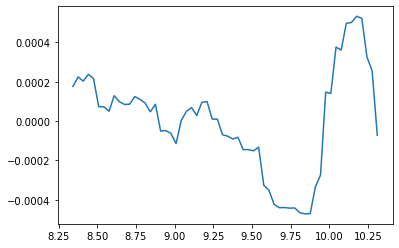

In [20]:
mm = A[250:310]
mm = mm- np.mean(mm)
plt.plot(time_sec[250:310], mm)

In [18]:
2/time_sec[1]

59.93545550796305

In [95]:
fs

50.030718861387506

In [51]:
%matplotlib qt
SS = ndimage.gaussian_filter(A,3)
SS = SS - np.mean(SS)
SS_g = np.gradient(SS)
plt.plot(SS, alpha = 0.5)
plt.plot(SS_g, alpha=0.5)

In [53]:
ff = pd.read_csv('./data/trial_frames.csv')
ff

,Subject_ID,Task,init_Frame,end_Frame
0,PD01,BBP,150,1500
1,PD01,PA,290,1540
2,PD01,BIGSMILE,240,1237
3,PD02,BBP,170,1500
4,PD02,PA,200,1370
5,PD02,BIGSMILE,40,570
6,PD03,BBP,216,2600
7,PD03,PA,295,800
8,PD03,BIGSMILE,54,811
9,PD04,BBP,140,1144


In [130]:
from PyEMD import EMD


In [277]:
emd = EMD()
emd.extrema_detection = "parabol"
IMF = emd.emd(lp_signal)


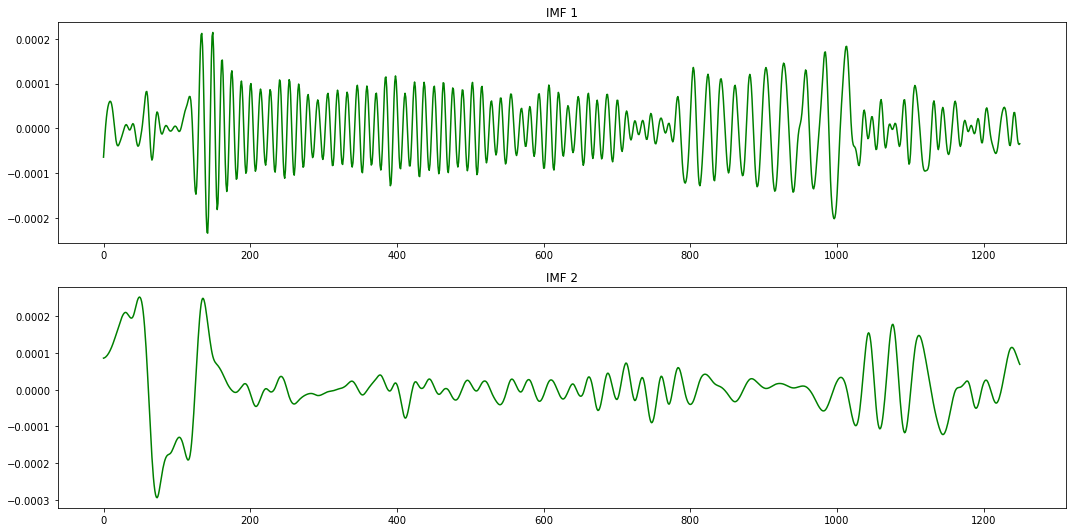

In [278]:
%matplotlib inline
N = IMF.shape[0]
fig, axis = plt.subplots(N,1,figsize=(15,7.5)) 
for n, imf in enumerate(IMF):
    axis[n].plot(imf, 'g')
    axis[n].set_title("IMF "+str(n+1))
plt.tight_layout()

In [174]:
NFFT = 128
nfilt = 20
sample_rate = 1/time_sec[1]

signal = A-np.mean(A)

frame_length, frame_step = 50, 25  # Convert from seconds to samples
signal_length = len(signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

frames *= np.hamming(frame_length)

mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

Text(0, 0.5, 'Frequency (Hz)')

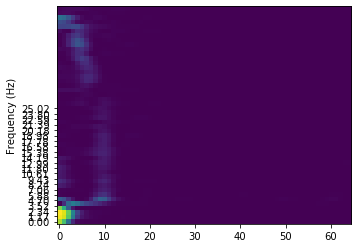

In [179]:
plt.imshow(pow_frames, origin='lower')
plt.yticks(hz_points)
plt.ylabel("Frequency (Hz)")

In [180]:
pow_frames.shape

(48, 65)

In [181]:
hz_points.shape

(22,)

In [184]:
bin.shape

(22,)

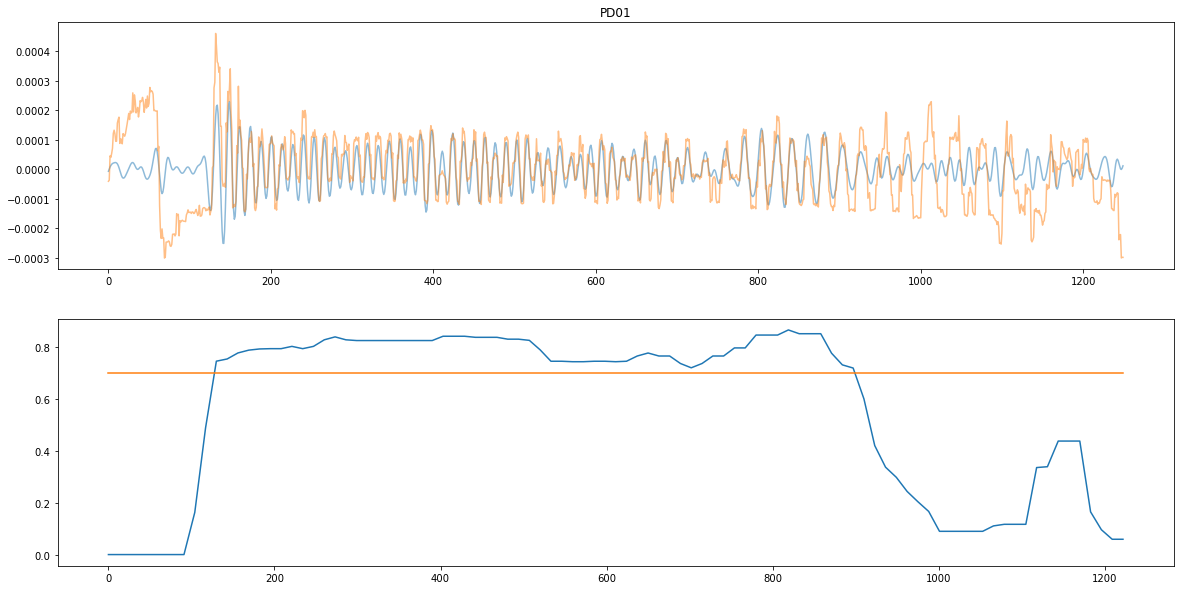

In [10]:
nwin = 25
overlap = 50; #in %
noverlap = int(nwin*(overlap/100))
err = []
posi = []
step = nwin - noverlap

fs = int(1/time_sec[1])
nyq = 0.5 * fs
lowcut = 2
highcut = 5
order = 6
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(order, [low, high], btype='band')
lp_signal  = signal.filtfilt(b, a, A)


seq1 = A-np.mean(A)
seq2 = lp_signal

for i in range(0, len(seq1) - nwin + 1, step):
    window1 = seq1[i:i+nwin] #this is a view, not a copy
    window2 = seq2[i:i+nwin] #this is a view, not a copy
    sq_error = np.sqrt(np.sum(window1-window2)**2)
    factor1 = np.var(window1-window2)
    factor2 = np.var(window1)
    VAF = (1- (factor1/factor2))
    if VAF<0:VAF=0
    err.append(VAF)  
    
    #err.append(sq_error)
    posi.append(i)
    
fig, ax = plt.subplots(2,1, figsize=(20,10))
    
ax[0].plot(lp_signal ,alpha=0.5)
ax[0].plot(A-np.mean(A), alpha = 0.5)
ax[0].set_title(Features.Subject_ID)

err_filt = signal.medfilt(err,9)
ax[1].plot(posi,err_filt)
ax[1].plot(posi, 0.7*np.ones((len(posi))))

# plt.plot(lp_signal*10000+3)


# first_time = False
# last_time = False
# for k, zeros in enumerate(zer):
#     if (zeros>=3) and (first_time is False):
#         init_position = posi[k+1]
#         first_time = True
        
#     if (zeros<3) and (first_time is True):
#         end_position = posi[k-1]
#         break
        
# init_position, end_position

In [302]:
sequence = A - np.mean(A)
fs = 1/time_sec[1]
M = 50
freqs, times, Sx = signal.spectrogram(sequence, fs=fs, window='hanning',
                                      nperseg=128, noverlap=M - 25,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs , 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency')
ax.set_xlabel('Time [s]');

In [304]:
plt.plot(freqs,Sx)

In [1]:
from statsmodels.tsa.ar_model import AR

In [211]:
def find_periodic_segments(seq, fs, nwin=50, overlap=50, lowcut=2, highcut=7, order=4, w=9):

    noverlap = int(nwin*(overlap/100))
    err = []
    posi = []
    step = nwin - noverlap

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')


    lp_signal  = signal.filtfilt(b, a,seq)

    seq1 = seq
    seq2 = lp_signal

    for i in range(0, len(seq1) - nwin + 1, step):
        window1 = seq1[i:i+nwin].astype(np.float) #this is a view, not a copy
        #window2 = seq2[i:i+nwin] #this is a view, not a copy
        window2  = signal.filtfilt(b, a,window1)
        factor1 = np.var(window1-window2)
        factor2 = np.var(window1)
        VAF = (1- (factor1/factor2))*100
        if VAF<0:VAF=0
        err.append(VAF)  
        posi.append(i)
    

    idx = np.where(signal.medfilt(err,w) > 0.8*np.max(signal.medfilt(err,w)))

    init_pos = posi[idx[0][0]]
    end_pos = posi[idx[0][-1]]

    return init_pos, end_pos, np.array(posi), signal.medfilt(err,w)

In [348]:
%matplotlib inline
paths = [r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Healthy', r'C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\Parkinsons']
tasks = ['REST', 'PA', 'BBP', 'BIGSMILE']

window_lenght_filter = 5

results = dict()

frames_interest = pd.read_csv('./data/trial_frames.csv')

all_data ={}
aux = 0
for path in paths:   
    Files = os.listdir(path)            
    ext='Landmarks3D.csv'
    Files = [i for i in Files if ext in i]
    for k,f in enumerate(Files):
        data =[]
        Files[k] = os.path.join(path,f)
        
        Features = Variables_Placeholder()
        
        Features.Subject_ID = f[0:4]  #get subject ID from file name
        Features.Subject_status = f[0:2] #get disease status from file name
            
            
        this_task = None
        
        for t in tasks: 
            if t in f: this_task = t  #get task from file name
             
        DataFrame3dInfo = pd.read_csv(Files[k])
        Right_Corner_Coord, Left_Corner_Coord, Top_Lip_Coord, Bottom_Lip_Coord = get_mouth_positions_3d(DataFrame3dInfo)  # get the four corners of the mouth :) 
        time_sec = DataFrame3dInfo['Time_Stamp (s)'].values[1:]
        

        
        if this_task is 'PA':
            # i will consider only the middle 20% of the video to take the measurements 
            # this is done with the assumption that the subject was at 'rest' at least during the middle of the video 
            init_point = frames_interest['init_Frame'][(frames_interest.Subject_ID == Features.Subject_ID) & (frames_interest.Task == this_task)].values[0]
            end_point = frames_interest['end_Frame'][(frames_interest.Subject_ID == Features.Subject_ID) & (frames_interest.Task == this_task)].values[0]
            if np.isnan(init_point):
                mid_point = len(Right_Corner_Coord)//2
                init_point = mid_point-int(len(Right_Corner_Coord)*0.3)
                end_point = mid_point+int(len(Right_Corner_Coord)*0.3)
            else:
                init_point = int(init_point)
                end_point = int(end_point)

            A_l = area_of_triangle(Left_Corner_Coord[:,:], Top_Lip_Coord[:,:], Bottom_Lip_Coord[:,:])
            A_r = area_of_triangle(Right_Corner_Coord[:,:], Top_Lip_Coord[:,:], Bottom_Lip_Coord[:,:])
            A = A_l  + A_r
            
            init_pos, end_pos, _, _ = find_periodic_segments(A-np.mean(A), 1/time_sec[1])

            #TB = np.sqrt((Top_Lip_Coord[init_point:end_point,0]-Bottom_Lip_Coord[init_point:end_point,0])**2+(Top_Lip_Coord[init_point:end_point,1]-Bottom_Lip_Coord[init_point:end_point,1])**2+(Top_Lip_Coord[init_point:end_point,2]-Bottom_Lip_Coord[init_point:end_point,2])**2)
            
#             #break
#             fig, ax = plt.subplots(1,2, figsize=(20,5))
    
#             ax[0].plot(time_sec, A ,alpha=0.5)
#             #ax[0].set_ylim([0, 0.005])
#             ax[1].plot(time_sec[init_pos:end_pos], A[init_pos:end_pos] ,alpha=0.5)
#             ax[0].set_title(Features.Subject_ID)
#             plt.show()
            
            
            fs = int(1/time_sec[1])
            nyq = 0.5 * fs
            lowcut = 2
            highcut = 7
            order = 4
            low = lowcut / nyq
            high = highcut / nyq
            b, a = signal.butter(order, [low, high], btype='band')
            segment = A[init_pos:end_pos]
            lp_signal  = signal.filtfilt(b, a, segment)
            vel_signal = np.gradient(lp_signal, time_sec[init_pos:end_pos])
            lp_vel_signal = signal.filtfilt(b, a, vel_signal)

            peaks_pos, _ = signal.find_peaks(lp_signal,distance=5)
            peaks_neg, _ = signal.find_peaks(-lp_signal,distance=5)

#             zero_crossings = np.where(np.diff(np.sign(lp_signal)))[0]
#             #peaks_neg, _ = signal.find_peaks(-vel_signal, height=0.05)
#             fig, ax = plt.subplots(1,1, figsize=(20,5))
#             plt.plot(segment ,alpha=0.5)
#             plt.scatter(peaks_pos,segment[peaks_pos],c='r' )
#             plt.scatter(peaks_neg,segment[peaks_neg],c='g' )
#             #plt.scatter(zero_crossings,segment[zero_crossings],c='m', alpha=0.75 )
#             plt.title(Features.Subject_ID)
            
#             if 'NF14' in Features.Subject_ID  :
#                 signal_interest = A
#                 time_interest = time_sec
#                 init_pos_interest = init_pos
#                 end_pos_interest = end_pos

            point_one_list= []
            point_two_list = []
            error_list = []
            final_point_one_list = []
            final_point_two_list = []
            for m in range(0, len(peaks_neg)-1,1):
                point_one = peaks_neg[m]
                point_two = peaks_neg[m+1]
                piece_of_data = segment[point_one:point_two+1]
                piece_of_data_filtered = lp_signal[point_one:point_two+1]
                factor1 = np.var(piece_of_data-piece_of_data_filtered)
                factor2 = np.var(piece_of_data)
                VAF = (1- (factor1/factor2))*100
                VAF=0 if VAF<0 else VAF
                point_one_list.append(point_one)
                point_two_list.append(point_two)
                error_list.append(VAF)

                idx = np.where(error_list > 0.8*np.max(error_list))

            for index in idx[0]:
                final_point_one_list.append(point_one_list[index])
                final_point_two_list.append(point_two_list[index])

#             fig, ax = plt.subplots(1,1, figsize=(20,5))  
#             plt.plot(segment ,alpha=0.5,linewidth=0.25, color='r')
#             for p1,p2 in zip(final_point_one_list,final_point_two_list):
#                 plt.plot(range(p1,p2+1),segment[p1:p2+1],linewidth=2, alpha =1)
#             #plt.scatter(final_point_one_list,segment[final_point_one_list],c='r' , alpha=0.75)
#             #plt.scatter(final_point_two_list,segment[final_point_two_list],c='g', alpha = 0.75 )
#             #plt.scatter(peaks_neg,segment[peaks_neg],c='g' )            
#             plt.title(Features.Subject_ID)

#             plt.show()
            
            data.append(Features.Subject_ID)
            data.append(this_task)
            for p1,p2 in zip(final_point_one_list,final_point_two_list):
                st = str(init_pos+p1)+':'+str(init_pos+p2+1)
                data.append(st)
            
            all_data[aux] = data
            aux +=1


In [366]:
df = pd.DataFrame.from_dict(all_data, orient='index')

cols = df.columns
new_names = ['Subject_ID','Task']
for i in range(2):
    df.rename(columns={cols[i]:new_names[i]}, inplace = True)
df.to_csv(r"C:\Users\GuarinD\Documents\GitHub\Face_and_Gestures_2020\data\results_PA.csv")